# Volatility Spike Mean Reversion Strategy

## Strategy Overview

This notebook implements and tests a volatility mean reversion strategy:

### Hypothesis
When at-the-money (ATM) near-term implied volatility spikes significantly above its historical average, it tends to revert to the mean within a predictable timeframe.

### Strategy Rules
1. **Calculate baseline**: Compute rolling average and standard deviation of ATM near-term IV for SPY
2. **Identify spikes**: When IV exceeds mean + 1.5 standard deviations
3. **Enter trade**: Sell ~1-month ATM straddle when spike occurs
4. **Exit trade**: Hold until expiration

### Dataset Note
The DoltHub options dataset contains monthly options with DTEs around 14, 28, and 46+ days. We use the front-month (14-15 DTE) options for volatility measurement and sell next-month (28-30 DTE) straddles.

### Metrics to Analyze
- Average time for IV to revert after spike
- Profitability of selling straddles during high IV
- Maximum drawdowns and consecutive losses
- Risk-adjusted returns (Sharpe, Sortino, Omega)

## Let's Begin!

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, str(Path.cwd().parent))

from backtester import (
    DoltHubAdapter,
    MarketDataLoader,
    StraddleStrategy,
    BacktestEngine,
    BacktestConfig,
    BlackScholesModel,
    PerformanceMetrics,
    VisualizationEngine
)

# Plotting setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")

✓ Imports successful


## Step 1: Load SPY Options Data

In [2]:
# Configuration
DB_PATH = "/Users/janussuk/Desktop/dolt_data/options"
TICKER = "SPY"

# Use multi-year dataset to get good statistics
START_DATE = "2022-01-01"
END_DATE = "2024-12-31"

print(f"Loading {TICKER} data from {START_DATE} to {END_DATE}...")

# Create adapter
adapter = DoltHubAdapter(DB_PATH)

# Load full options chain for analysis
options_data = adapter.load_option_data(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE
)

print(f"\n✓ Loaded {len(options_data):,} option records")
print(f"  Date range: {options_data['date'].min().date()} to {options_data['date'].max().date()}")
print(f"  Unique dates: {options_data['date'].nunique()}")

Loading SPY data from 2022-01-01 to 2024-12-31...

✓ Loaded 63,448 option records
  Date range: 2022-01-03 to 2024-12-31
  Unique dates: 484


## Step 2: Calculate ATM Near-Term Implied Volatility

**Note:** The DoltHub dataset contains monthly options with DTEs around 14, 28, and 46+ days. We'll use the nearest-term options (14-18 DTE) as a proxy for short-term volatility.

In [3]:
# Load spot data
loader = MarketDataLoader(adapter)
spot_data = adapter.load_spot_data(TICKER, START_DATE, END_DATE)

print(f"Spot data loaded: {len(spot_data)} days")
print(f"Price range: ${spot_data['close'].min():.2f} - ${spot_data['close'].max():.2f}")

Spot data loaded: 752 days
Price range: $342.19 - $600.51


In [4]:
def get_atm_nearterm_iv(options_df, spot_prices):
    """
    Extract ATM near-term (front-month) implied volatility for each date.
    Uses options with 12-18 days to expiration (closest to monthly cycle).
    
    Returns: DataFrame with date, atm_iv_nearterm, days_to_exp
    """
    results = []
    
    for date in options_df['date'].unique():
        # Get options for this date
        day_options = options_df[options_df['date'] == date].copy()
        
        # Get spot price
        date_ts = pd.Timestamp(date)
        if date_ts not in spot_prices.index:
            continue
        spot = spot_prices.loc[date_ts, 'close']
        
        # Calculate days to expiration
        day_options['dte'] = (day_options['expiration'] - day_options['date']).dt.days
        
        # Filter to near-term options (12-18 days for monthly options)
        nearterm_options = day_options[(day_options['dte'] >= 12) & (day_options['dte'] <= 18)]
        
        if len(nearterm_options) == 0:
            continue
        
        # Find ATM strike (closest to spot)
        nearterm_options['strike_dist'] = abs(nearterm_options['strike'] - spot)
        atm_strike = nearterm_options.loc[nearterm_options['strike_dist'].idxmin(), 'strike']
        
        # Get ATM straddle IV (average of call and put)
        atm_options = nearterm_options[nearterm_options['strike'] == atm_strike]
        
        if len(atm_options) >= 2:  # Need both call and put
            atm_iv = atm_options['implied_vol'].mean()
            avg_dte = atm_options['dte'].mean()
            
            results.append({
                'date': date,
                'spot': spot,
                'atm_strike': atm_strike,
                'atm_iv_nearterm': atm_iv,
                'days_to_exp': avg_dte
            })
    
    return pd.DataFrame(results)

print("Calculating ATM near-term IV...")
atm_iv_df = get_atm_nearterm_iv(options_data, spot_data)

print(f"\n✓ Calculated ATM IV for {len(atm_iv_df)} trading days")
if len(atm_iv_df) > 0:
    print(f"  Average IV: {atm_iv_df['atm_iv_nearterm'].mean():.2%}")
    print(f"  IV Range: {atm_iv_df['atm_iv_nearterm'].min():.2%} to {atm_iv_df['atm_iv_nearterm'].max():.2%}")
    print(f"  Average DTE: {atm_iv_df['days_to_exp'].mean():.1f} days")
    display(atm_iv_df.head())
else:
    print("  ⚠️ No data found - check date range and DTE filtering")

Calculating ATM near-term IV...

✓ Calculated ATM IV for 424 trading days
  Average IV: 19.26%
  IV Range: 8.77% to 39.86%
  Average DTE: 14.0 days


,date,spot,atm_strike,atm_iv_nearterm,days_to_exp
0,2022-01-03,453.210419,449.0,0.19320,15.0
1,2022-01-05,444.358978,440.0,0.24300,14.0
2,2022-01-07,442.186279,438.0,0.22125,14.0
3,2022-01-10,441.636139,438.0,0.22930,14.0
4,2022-01-12,446.863464,442.0,0.22200,14.0


## Step 3: Analyze Volatility Statistics

Calculate rolling mean, standard deviation, and identify spike conditions.

In [5]:
# Calculate rolling statistics
LOOKBACK_WINDOW = 60  # 60 trading days (~3 months)

atm_iv_df = atm_iv_df.sort_values('date').reset_index(drop=True)
atm_iv_df['iv_mean'] = atm_iv_df['atm_iv_nearterm'].rolling(LOOKBACK_WINDOW, min_periods=20).mean()
atm_iv_df['iv_std'] = atm_iv_df['atm_iv_nearterm'].rolling(LOOKBACK_WINDOW, min_periods=20).std()

# Calculate z-score
atm_iv_df['iv_zscore'] = (atm_iv_df['atm_iv_nearterm'] - atm_iv_df['iv_mean']) / atm_iv_df['iv_std']

# Identify spikes (1.5 std above mean)
SPIKE_THRESHOLD = 1.5
atm_iv_df['is_spike'] = atm_iv_df['iv_zscore'] > SPIKE_THRESHOLD

print(f"Volatility Statistics:")
print(f"  Average IV: {atm_iv_df['atm_iv_nearterm'].mean():.2%}")
print(f"  Std Dev: {atm_iv_df['atm_iv_nearterm'].std():.2%}")
print(f"  Total spikes detected: {atm_iv_df['is_spike'].sum()}")
print(f"  Spike frequency: {atm_iv_df['is_spike'].sum() / len(atm_iv_df):.1%}")

Volatility Statistics:
  Average IV: 19.26%
  Std Dev: 6.73%
  Total spikes detected: 29
  Spike frequency: 6.8%


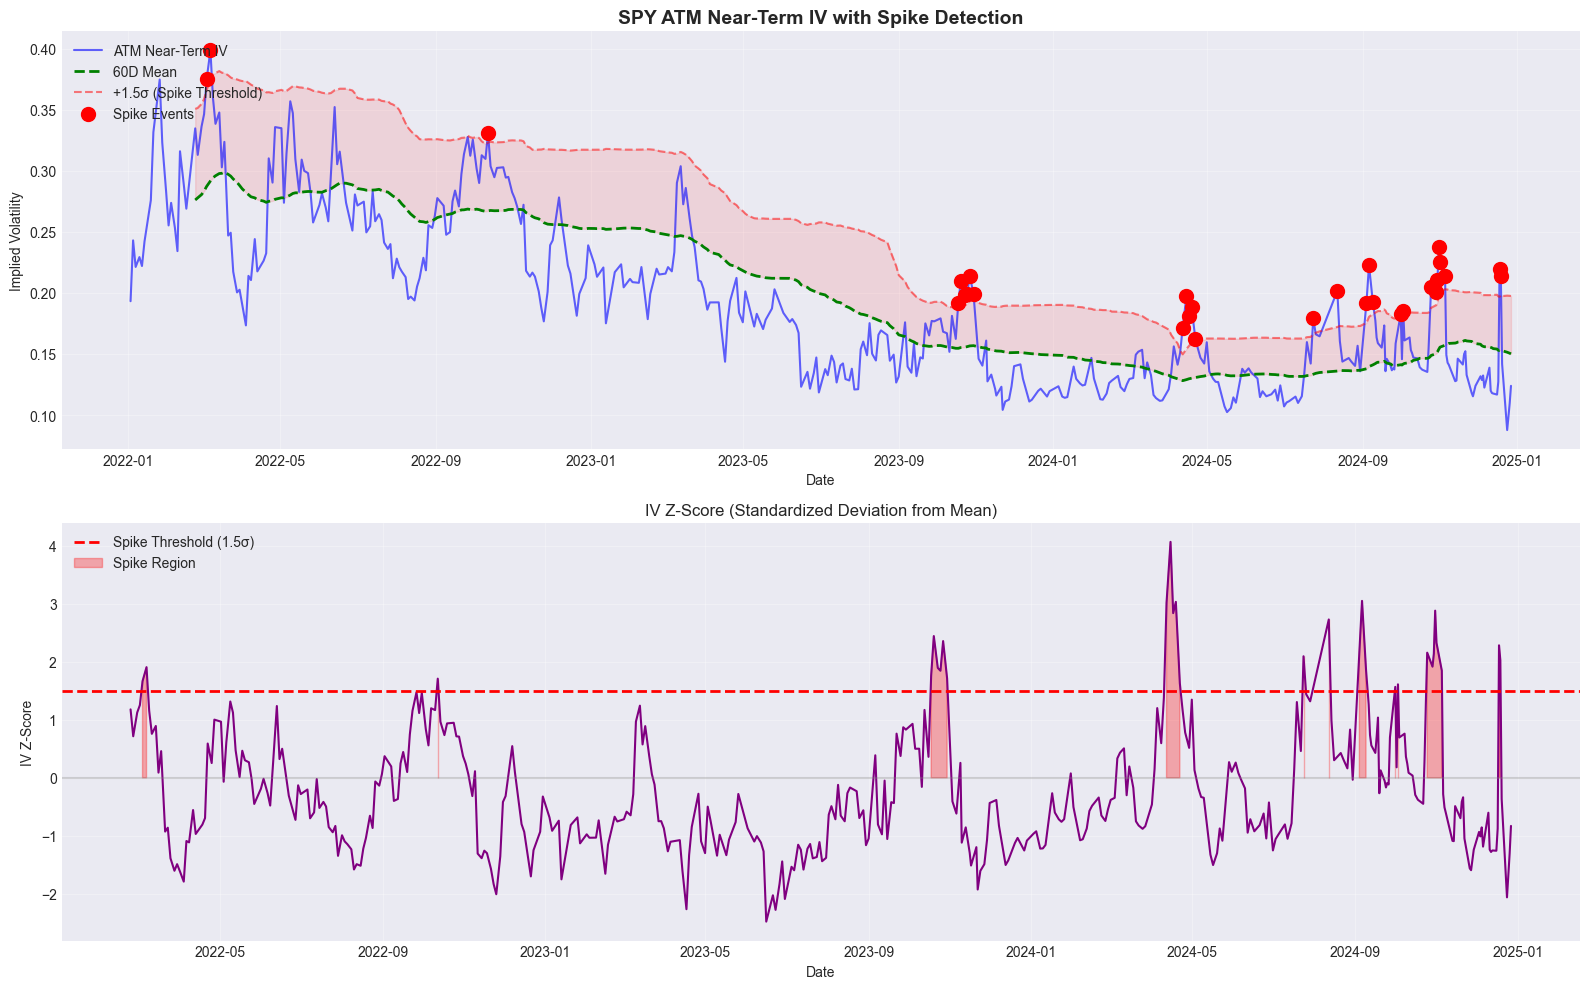


📊 Identified 29 spike events for strategy entry


In [6]:
# Visualize IV over time with spike markers
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: IV with rolling mean and bands
ax1.plot(atm_iv_df['date'], atm_iv_df['atm_iv_nearterm'], 'b-', alpha=0.6, label='ATM Near-Term IV')
ax1.plot(atm_iv_df['date'], atm_iv_df['iv_mean'], 'g--', linewidth=2, label=f'{LOOKBACK_WINDOW}D Mean')

# Add bands
upper_band = atm_iv_df['iv_mean'] + SPIKE_THRESHOLD * atm_iv_df['iv_std']
ax1.plot(atm_iv_df['date'], upper_band, 'r--', alpha=0.5, label=f'+{SPIKE_THRESHOLD}σ (Spike Threshold)')
ax1.fill_between(atm_iv_df['date'], atm_iv_df['iv_mean'], upper_band, alpha=0.1, color='red')

# Mark spikes
spike_dates = atm_iv_df[atm_iv_df['is_spike']]
ax1.scatter(spike_dates['date'], spike_dates['atm_iv_nearterm'], color='red', s=100, 
           marker='o', label='Spike Events', zorder=5)

ax1.set_xlabel('Date')
ax1.set_ylabel('Implied Volatility')
ax1.set_title(f'{TICKER} ATM Near-Term IV with Spike Detection', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Z-score
ax2.plot(atm_iv_df['date'], atm_iv_df['iv_zscore'], 'purple', linewidth=1.5)
ax2.axhline(y=SPIKE_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Spike Threshold ({SPIKE_THRESHOLD}σ)')
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax2.fill_between(atm_iv_df['date'], 0, atm_iv_df['iv_zscore'], 
                where=(atm_iv_df['iv_zscore'] > SPIKE_THRESHOLD), 
                color='red', alpha=0.3, label='Spike Region')

ax2.set_xlabel('Date')
ax2.set_ylabel('IV Z-Score')
ax2.set_title('IV Z-Score (Standardized Deviation from Mean)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Identified {len(spike_dates)} spike events for strategy entry")

## Step 4: Analyze Mean Reversion Time

How long does it take for IV to return to normal levels after a spike?


Mean Reversion Analysis:
  Spikes that reverted: 29 / 29
  Average reversion time: 4.6 trading days
  Median reversion time: 5.0 trading days
  Range: 1 - 10 days


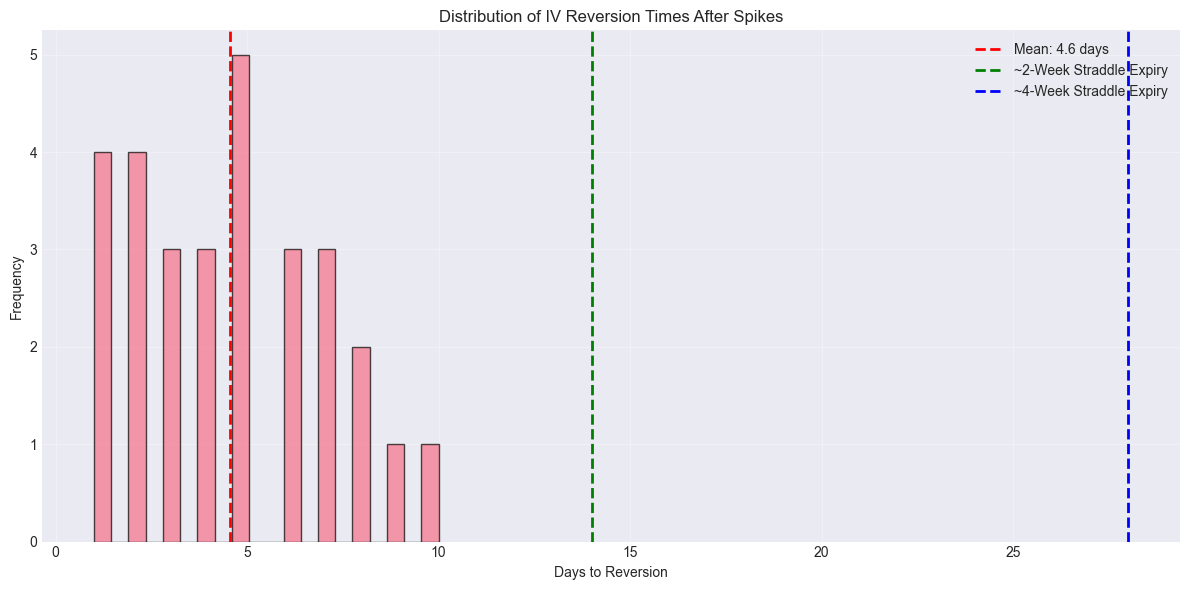

,spike_date,spike_iv,mean_iv,revert_date,days_to_revert
0,2022-03-04,0.37475,0.287171,2022-03-16,5
1,2022-03-07,0.39860,0.291628,2022-03-16,4
2,2022-10-12,0.33085,0.267147,2022-10-31,7
3,2023-10-18,0.19210,0.154631,2023-11-03,6
4,2023-10-20,0.20985,0.155254,2023-11-03,5
5,2023-10-23,0.19865,0.155518,2023-11-03,4
6,2023-10-25,0.19915,0.155997,2023-11-03,3
7,2023-10-27,0.21410,0.156599,2023-11-03,2
8,2023-10-30,0.19910,0.156798,2023-11-03,1
9,2024-04-12,0.17155,0.128147,2024-05-06,10


In [7]:
def calculate_reversion_time(iv_df, spike_threshold=1.5):
    """
    Calculate time for IV to revert below spike threshold after each spike.
    """
    reversion_times = []
    
    iv_df = iv_df.sort_values('date').reset_index(drop=True)
    spike_indices = iv_df[iv_df['is_spike']].index.tolist()
    
    for spike_idx in spike_indices:
        spike_date = iv_df.loc[spike_idx, 'date']
        spike_iv = iv_df.loc[spike_idx, 'atm_iv_nearterm']
        mean_iv = iv_df.loc[spike_idx, 'iv_mean']
        
        # Look forward to find when IV drops below mean + 0.5*std
        revert_threshold = mean_iv + 0.5 * iv_df.loc[spike_idx, 'iv_std']
        
        days_to_revert = None
        revert_date = None
        for i in range(spike_idx + 1, min(spike_idx + 30, len(iv_df))):
            if iv_df.loc[i, 'atm_iv_nearterm'] < revert_threshold:
                days_to_revert = i - spike_idx
                revert_date = iv_df.loc[i, 'date']
                break
        
        if days_to_revert is not None:
            reversion_times.append({
                'spike_date': spike_date,
                'spike_iv': spike_iv,
                'mean_iv': mean_iv,
                'revert_date': revert_date,
                'days_to_revert': days_to_revert
            })
    
    return pd.DataFrame(reversion_times)

reversion_df = calculate_reversion_time(atm_iv_df)

if len(reversion_df) > 0:
    print(f"\nMean Reversion Analysis:")
    print(f"  Spikes that reverted: {len(reversion_df)} / {atm_iv_df['is_spike'].sum()}")
    print(f"  Average reversion time: {reversion_df['days_to_revert'].mean():.1f} trading days")
    print(f"  Median reversion time: {reversion_df['days_to_revert'].median():.1f} trading days")
    print(f"  Range: {reversion_df['days_to_revert'].min():.0f} - {reversion_df['days_to_revert'].max():.0f} days")
    
    # Plot distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(reversion_df['days_to_revert'], bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(reversion_df['days_to_revert'].mean(), color='red', linestyle='--', 
              linewidth=2, label=f'Mean: {reversion_df["days_to_revert"].mean():.1f} days')
    ax.axvline(14, color='green', linestyle='--', linewidth=2, label='~2-Week Straddle Expiry')
    ax.axvline(28, color='blue', linestyle='--', linewidth=2, label='~4-Week Straddle Expiry')
    ax.set_xlabel('Days to Reversion')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of IV Reversion Times After Spikes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    display(reversion_df.head(10))
else:
    print("\n⚠️ Not enough spike events to analyze reversion")

## Step 5: Implement and Backtest the Strategy

Now let's trade this strategy: sell ATM straddles when spikes occur.

**Note:** Since the dataset has monthly options, we'll sell the next-month cycle (28-30 DTE) when spikes are detected.

In [8]:
# Create custom strategy class for volatility spike trading
class VolatilitySpikeStrategy:
    """
    Sell ATM straddles when IV spikes above threshold.
    """
    def __init__(self, iv_data, spike_threshold=1.5, straddle_dte=14):
        self.iv_data = iv_data.set_index('date')
        self.spike_threshold = spike_threshold
        self.straddle_dte = straddle_dte
        self.active_trades = {}
        
    def should_enter(self, date):
        """Check if we should enter a trade on this date."""
        if date not in self.iv_data.index:
            return False
        
        row = self.iv_data.loc[date]
        return row['is_spike'] if 'is_spike' in row else False
    
    def get_signal_dates(self):
        """Get all dates where spikes occurred."""
        spike_dates = self.iv_data[self.iv_data['is_spike'] == True].index.tolist()
        return spike_dates

print("✓ Strategy class defined")

✓ Strategy class defined


In [9]:
# Load market data for backtesting
print("Loading market data for backtesting...")

market_data = loader.load(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    build_vol_surface=True
)

print(f"✓ Market data loaded")

Loading market data for backtesting...
Loading market data for SPY...
  Loading spot prices...
  Loading options chain...
  Loading volatility data...
  Building volatility surfaces...
  Loaded 752 days of spot data
  Loaded 63448 option records
  Built 484 volatility surfaces
✓ Market data loaded


In [10]:
# Run backtest with multiple straddle trades
print("\n" + "="*60)
print("RUNNING VOLATILITY SPIKE STRATEGY BACKTEST")
print("="*60)

# Get spike dates
strategy_obj = VolatilitySpikeStrategy(atm_iv_df)
spike_dates = strategy_obj.get_signal_dates()

print(f"\nTotal spike signals: {len(spike_dates)}")
print(f"Testing period: {START_DATE} to {END_DATE}")

# Configure backtest
config = BacktestConfig(
    start_date=pd.Timestamp(START_DATE),
    end_date=pd.Timestamp(END_DATE),
    initial_capital=100000.0,
    transaction_cost_per_contract=0.65,
    model=BlackScholesModel(use_market_iv=True)
)

engine = BacktestEngine(market_data, config)

# Add straddles for each spike
trade_count = 0
skipped_count = 0
TARGET_DTE_MIN = 25  # Target ~30 day options
TARGET_DTE_MAX = 35

for spike_date in spike_dates:
    try:
        spike_date = pd.Timestamp(spike_date)
        
        # Get spot price
        spot = market_data.get_spot(spike_date)
        
        # Find available expirations with ~28-30 DTE from the actual dataset
        day_options = options_data[options_data['date'] == spike_date].copy()
        if len(day_options) == 0:
            skipped_count += 1
            continue
            
        day_options['dte'] = (day_options['expiration'] - day_options['date']).dt.days
        suitable_options = day_options[(day_options['dte'] >= TARGET_DTE_MIN) & 
                                      (day_options['dte'] <= TARGET_DTE_MAX)]
        
        if len(suitable_options) == 0:
            skipped_count += 1
            continue
        
        # Get the most common expiration in this DTE range
        expiry = suitable_options['expiration'].mode()[0]
        dte = (expiry - spike_date).days
        
        # Create short straddle (sell both call and put)
        straddle = StraddleStrategy(
            underlying=TICKER,
            strike=spot,  # ATM
            expiry=expiry,
            direction='short',  # We're selling volatility
            quantity=1.0
        )
        
        engine.add_strategy(straddle, entry_date=spike_date)
        trade_count += 1
        print(f"  ✓ Added trade on {spike_date.date()} (strike=${spot:.0f}, DTE={dte})")
        
    except Exception as e:
        print(f"  ✗ Skipped {spike_date.date()}: {str(e)[:80]}")
        skipped_count += 1
        continue

print(f"\n{'='*60}")
print(f"Successfully added {trade_count} straddle trades")
print(f"Skipped {skipped_count} signals (no suitable options)")
print(f"{'='*60}")

# Run backtest
if trade_count > 0:
    print("\n🏃 Running backtest...")
    results = engine.run()
    print("✓ Backtest completed successfully!")
    print(f"  Total days simulated: {len(results)}")
    print(f"  Final portfolio value: ${results['portfolio_value'].iloc[-1]:,.2f}")
else:
    print("\n✗ No trades to backtest - check date ranges and data availability")


RUNNING VOLATILITY SPIKE STRATEGY BACKTEST

Total spike signals: 29
Testing period: 2022-01-01 to 2024-12-31
  ✓ Added trade on 2022-03-04 (strike=$410, DTE=28)
  ✓ Added trade on 2022-03-07 (strike=$398, DTE=28)
  ✓ Added trade on 2022-10-12 (strike=$342, DTE=28)
  ✓ Added trade on 2023-10-18 (strike=$419, DTE=30)
  ✓ Added trade on 2023-10-20 (strike=$411, DTE=28)
  ✓ Added trade on 2023-10-23 (strike=$410, DTE=25)
  ✓ Added trade on 2023-10-25 (strike=$407, DTE=30)
  ✓ Added trade on 2023-10-27 (strike=$400, DTE=28)
  ✓ Added trade on 2023-10-30 (strike=$405, DTE=25)
  ✓ Added trade on 2024-04-12 (strike=$502, DTE=28)
  ✓ Added trade on 2024-04-15 (strike=$495, DTE=25)
  ✓ Added trade on 2024-04-17 (strike=$491, DTE=30)
  ✓ Added trade on 2024-04-19 (strike=$486, DTE=28)
  ✓ Added trade on 2024-04-22 (strike=$491, DTE=25)
  ✓ Added trade on 2024-07-24 (strike=$533, DTE=30)
  ✓ Added trade on 2024-08-12 (strike=$525, DTE=25)
  ✓ Added trade on 2024-09-04 (strike=$543, DTE=26)
  ✓ Ad

## Step 6: Performance Analysis

Let's analyze the strategy performance using our comprehensive metrics.

In [11]:
if trade_count > 0:
    # Calculate comprehensive metrics
    metrics = PerformanceMetrics(results, risk_free_rate=0.05)
    metrics.print_summary()
    
    # Save summary for later analysis
    summary = metrics.summary()


PERFORMANCE SUMMARY
Total Return                       :    -72.15%
Annualized Return                  :    -34.84%
Annualized Volatility              :  84862.81%
Sharpe Ratio                       :      -0.00
Sortino Ratio                      :      -0.00
Omega Ratio                        :       1.74
Max Drawdown                       :  -6302.35%
Calmar Ratio                       :      -0.01
Sterling Ratio                     :      -0.01
Ulcer Index                        :    1647.41
Win Rate                           :       0.52
Profit Factor                      :       1.74
Recovery Factor                    :      -0.01
Expectancy                         :    135.36%
Avg Win/Loss                       :       1.60
Max Consecutive Wins               :          7
Max Consecutive Losses             :          7
VaR (95%)                          :     96.73%
CVaR (95%)                         :   3430.23%
Skewness                           :      12.01
Kurtosis           

## Step 7: Visualize P&L Progression

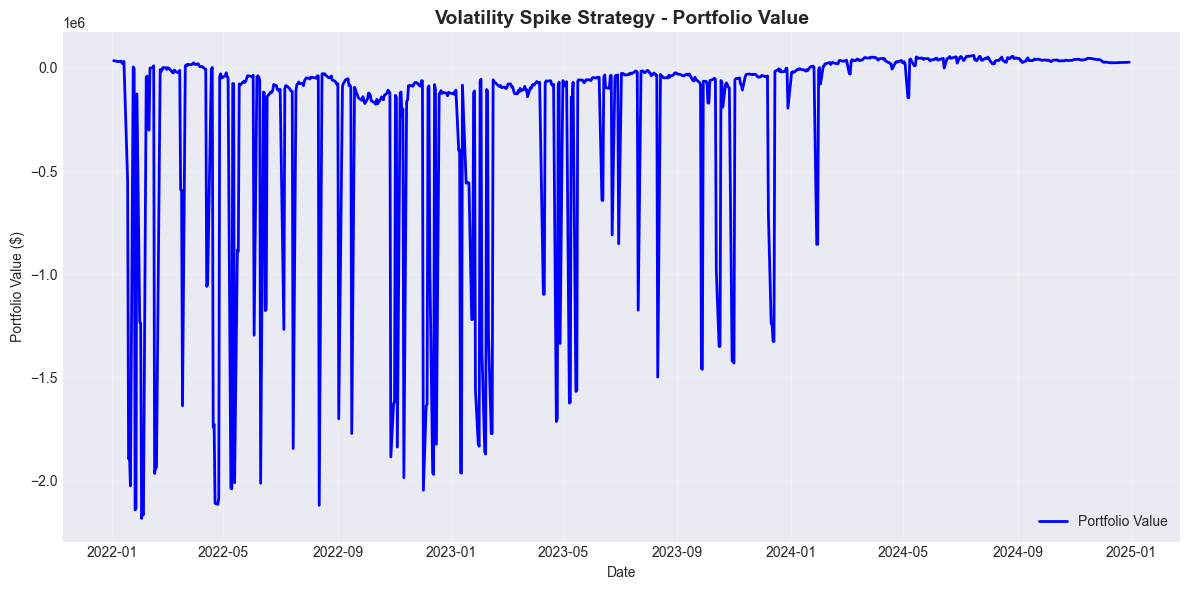

In [12]:
if trade_count > 0:
    # Create comprehensive visualizations
    viz = VisualizationEngine(use_plotly=False)
    
    # Equity curve
    viz.plot_equity_curve(results, title="Volatility Spike Strategy - Portfolio Value")

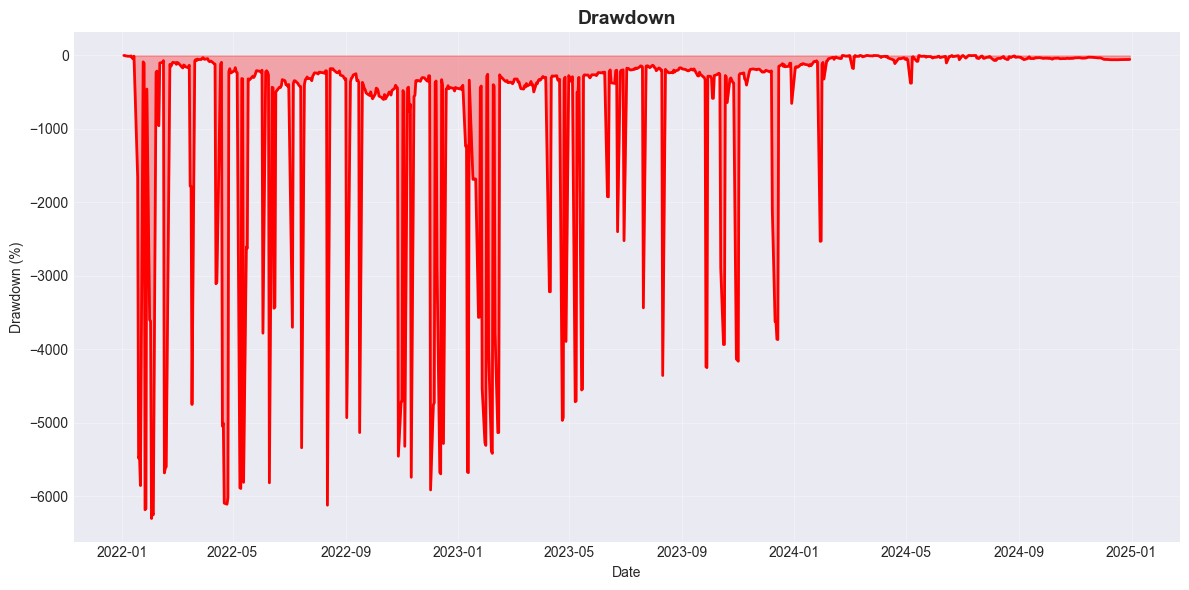

In [13]:
if trade_count > 0:
    # Drawdown analysis
    viz.plot_drawdown(results)

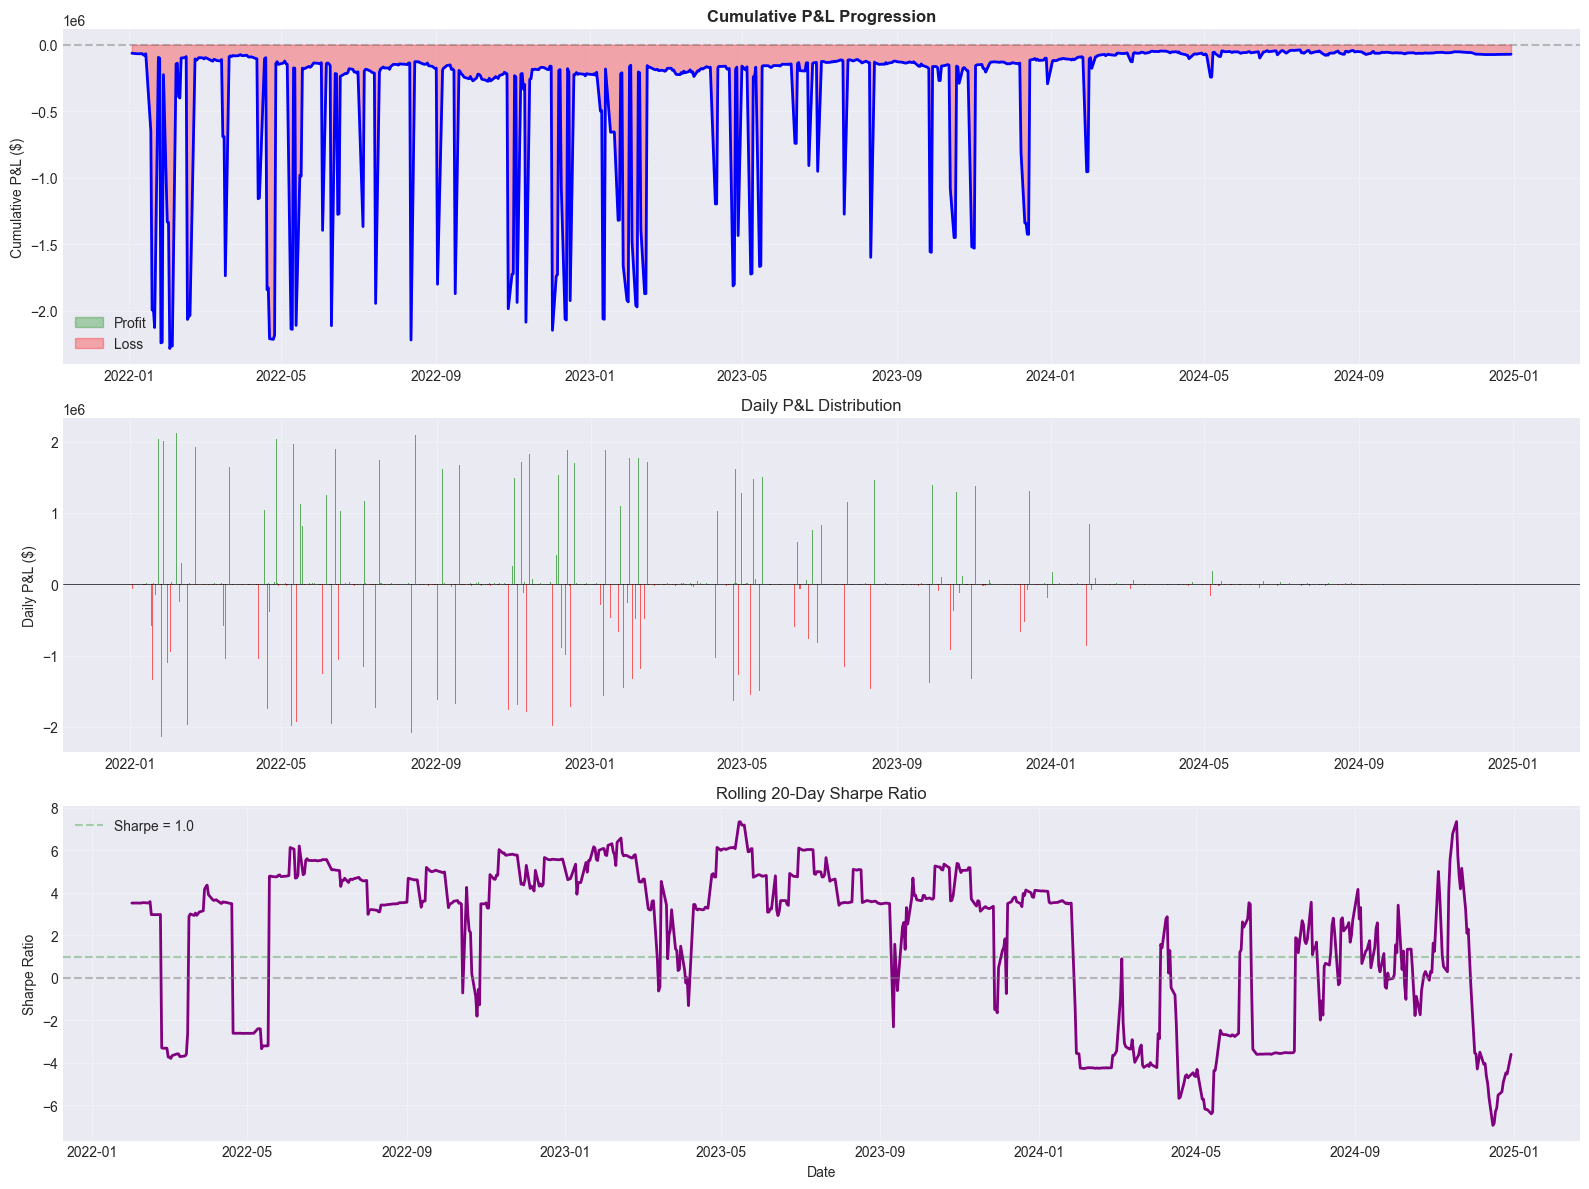

In [14]:
if trade_count > 0:
    # Custom P&L analysis with spike markers
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
    
    # Plot 1: Cumulative P&L
    cumulative_pnl = results['daily_pnl'].cumsum()
    ax1.plot(results.index, cumulative_pnl, 'b-', linewidth=2)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.fill_between(results.index, 0, cumulative_pnl, where=(cumulative_pnl > 0), 
                     color='green', alpha=0.3, label='Profit')
    ax1.fill_between(results.index, 0, cumulative_pnl, where=(cumulative_pnl < 0), 
                     color='red', alpha=0.3, label='Loss')
    ax1.set_ylabel('Cumulative P&L ($)')
    ax1.set_title('Cumulative P&L Progression', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Daily P&L
    colors = ['green' if x > 0 else 'red' for x in results['daily_pnl']]
    ax2.bar(results.index, results['daily_pnl'], color=colors, alpha=0.6, width=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_ylabel('Daily P&L ($)')
    ax2.set_title('Daily P&L Distribution')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Rolling Sharpe
    rolling_sharpe = metrics.rolling_sharpe(window=20)
    ax3.plot(rolling_sharpe.index, rolling_sharpe, 'purple', linewidth=2)
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax3.axhline(y=1, color='green', linestyle='--', alpha=0.3, label='Sharpe = 1.0')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Sharpe Ratio')
    ax3.set_title('Rolling 20-Day Sharpe Ratio')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 8: Identify Loss Cases

Let's analyze when and why large losses occurred.

In [15]:
if trade_count > 0:
    # Find worst performing days
    WORST_DAYS_COUNT = 10
    
    worst_days = results.nsmallest(WORST_DAYS_COUNT, 'daily_pnl')[[
        'spot', 'daily_pnl', 'delta', 'gamma', 'vega', 'theta'
    ]]
    
    print("\n" + "="*70)
    print(f"TOP {WORST_DAYS_COUNT} WORST PERFORMING DAYS")
    print("="*70)
    print(worst_days)
    
    # Analyze characteristics of loss days
    loss_days = results[results['daily_pnl'] < 0]
    
    print(f"\n\nLoss Day Statistics:")
    print(f"  Total loss days: {len(loss_days)} ({len(loss_days)/len(results):.1%})")
    print(f"  Average loss: ${loss_days['daily_pnl'].mean():,.2f}")
    print(f"  Worst loss: ${loss_days['daily_pnl'].min():,.2f}")
    print(f"  Median loss: ${loss_days['daily_pnl'].median():,.2f}")


TOP 10 WORST PERFORMING DAYS
                  spot     daily_pnl        delta     gamma         vega  \
date                                                                       
2022-01-26  411.153900 -2.139777e+06 -2715.983307 -2.569281  -422.358070   
2022-08-12  408.210541 -2.081456e+06 -2656.295268 -0.528719  -181.278964   
2022-05-09  378.923157 -1.989860e+06 -2637.257754 -0.334128  -215.004498   
2022-12-02  390.511078 -1.984451e+06 -2544.749675 -0.087541  -467.340271   
2022-02-16  423.695923 -1.975766e+06 -2547.320131 -3.799359 -2260.905918   
2022-06-10  370.957794 -1.954240e+06 -2639.315211 -0.779306  -197.982383   
2022-05-13  382.301605 -1.933802e+06 -2603.710293 -0.623729  -611.000440   
2022-11-11  382.449646 -1.787074e+06 -2495.794369 -0.180623  -757.013015   
2022-10-28  373.342041 -1.765459e+06 -2474.977375 -1.667620 -1231.831006   
2022-04-20  423.213531 -1.743735e+06 -2219.240404 -1.789905 -3328.942663   

                 theta  
date                    
2022-01


Spot Price Movement on Loss Days:
  Average spot change: 0.08%
  Max spot move: 6.87%
  Min spot move: -5.52%


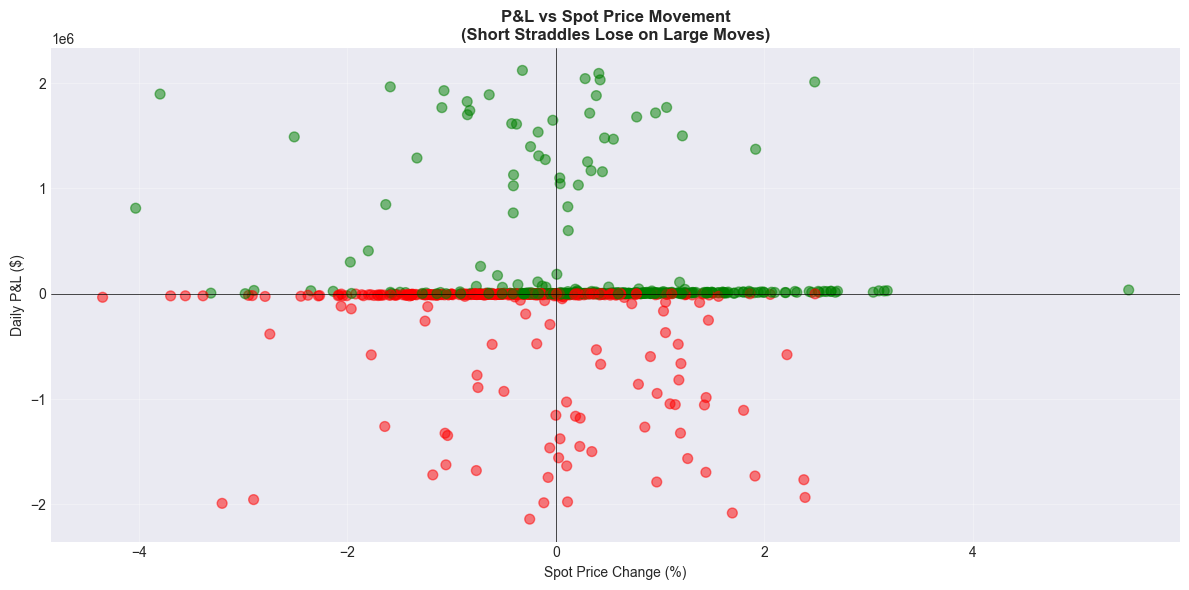

In [16]:
if trade_count > 0:
    # Analyze spot price movements on loss days
    loss_days_copy = loss_days.copy()
    loss_days_copy['spot_change'] = loss_days_copy['spot'].pct_change()
    
    print("\nSpot Price Movement on Loss Days:")
    print(f"  Average spot change: {loss_days_copy['spot_change'].mean():.2%}")
    print(f"  Max spot move: {loss_days_copy['spot_change'].max():.2%}")
    print(f"  Min spot move: {loss_days_copy['spot_change'].min():.2%}")
    
    # Scatter plot: P&L vs spot movement
    fig, ax = plt.subplots(figsize=(12, 6))
    
    results_copy = results.copy()
    results_copy['spot_change'] = results_copy['spot'].pct_change()
    results_copy = results_copy.dropna()
    
    # Color by profit/loss
    colors = ['green' if x > 0 else 'red' for x in results_copy['daily_pnl']]
    ax.scatter(results_copy['spot_change']*100, results_copy['daily_pnl'], 
              c=colors, alpha=0.5, s=50)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Spot Price Change (%)')
    ax.set_ylabel('Daily P&L ($)')
    ax.set_title('P&L vs Spot Price Movement\n(Short Straddles Lose on Large Moves)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [17]:
if trade_count > 0:
    # Analyze consecutive losses
    print("\n" + "="*70)
    print("CONSECUTIVE LOSS ANALYSIS")
    print("="*70)
    
    print(f"Max consecutive losses: {metrics.max_consecutive_losses()} days")
    print(f"Max consecutive wins: {metrics.max_consecutive_wins()} days")
    
    # Find periods of consecutive losses
    results_copy = results.copy()
    results_copy['is_loss'] = results_copy['daily_pnl'] < 0
    results_copy['loss_streak'] = (results_copy['is_loss'] & 
                                   results_copy['is_loss'].shift(1)).cumsum()
    
    # Group by streak
    loss_streaks = results_copy[results_copy['is_loss']].groupby('loss_streak').agg({
        'daily_pnl': ['sum', 'count'],
        'spot': ['first', 'last']
    }).reset_index()
    
    if len(loss_streaks) > 0:
        loss_streaks.columns = ['streak_id', 'total_loss', 'days', 'start_spot', 'end_spot']
        loss_streaks = loss_streaks[loss_streaks['days'] >= 2].sort_values('total_loss')
        
        if len(loss_streaks) > 0:
            print(f"\nLongest loss streaks (>= 2 days):")
            print(loss_streaks.head(5))


CONSECUTIVE LOSS ANALYSIS
Max consecutive losses: 7 days
Max consecutive wins: 7 days

Longest loss streaks (>= 2 days):
    streak_id    total_loss  days  start_spot    end_spot
65         65 -3.607691e+06     6  361.182678  386.115601
8           8 -3.246604e+06     2  411.153900  426.836151
24         24 -3.179188e+06     3  421.881195  405.445984
91         91 -3.063906e+06     5  392.078918  405.134277
89         89 -2.913194e+06     4  398.611420  397.604950


## Step 9: Risk Analysis

Deep dive into risk metrics.


RISK ANALYSIS

Value at Risk (95% confidence):
  Daily VaR: $96,726.35
  Daily CVaR (Expected Shortfall): $3,430,234.58

Return Distribution:
  Skewness: 12.008
  Kurtosis: 393.168
  ⚠️  HIGH KURTOSIS: Fat tails - more extreme events than normal distribution


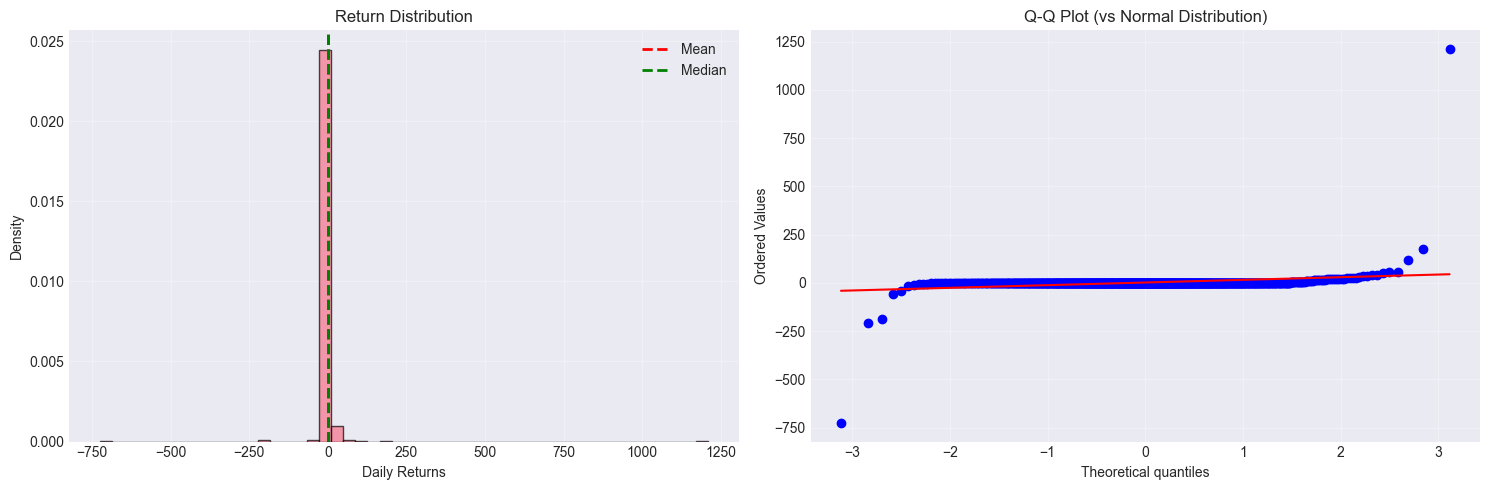

In [18]:
if trade_count > 0:
    print("\n" + "="*70)
    print("RISK ANALYSIS")
    print("="*70)
    
    # VaR and CVaR
    var_95 = metrics.value_at_risk(0.95)
    cvar_95 = metrics.conditional_var(0.95)
    
    print(f"\nValue at Risk (95% confidence):")
    print(f"  Daily VaR: ${var_95 * config.initial_capital:,.2f}")
    print(f"  Daily CVaR (Expected Shortfall): ${cvar_95 * config.initial_capital:,.2f}")
    
    # Distribution analysis
    print(f"\nReturn Distribution:")
    print(f"  Skewness: {metrics.skewness():.3f}")
    print(f"  Kurtosis: {metrics.kurtosis():.3f}")
    
    if metrics.skewness() < -0.5:
        print("  ⚠️  NEGATIVE SKEW: More extreme losses than gains (tail risk)")
    if metrics.kurtosis() > 3:
        print("  ⚠️  HIGH KURTOSIS: Fat tails - more extreme events than normal distribution")
    
    # Plot return distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    returns = results['returns'].dropna()
    ax1.hist(returns, bins=50, edgecolor='black', alpha=0.7, density=True)
    ax1.axvline(returns.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax1.axvline(returns.median(), color='green', linestyle='--', linewidth=2, label='Median')
    ax1.set_xlabel('Daily Returns')
    ax1.set_ylabel('Density')
    ax1.set_title('Return Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(returns, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot (vs Normal Distribution)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 10: Strategy Summary and Conclusions

In [19]:
if trade_count > 0:
    print("\n" + "#"*70)
    print("#" + " "*20 + "STRATEGY CONCLUSIONS" + " "*20 + "#")
    print("#"*70)
    
    print(f"\n📊 Trades Executed: {trade_count}")
    print(f"📈 Final Return: {summary['Total Return']:.2%}")
    print(f"📉 Max Drawdown: {summary['Max Drawdown']:.2%}")
    print(f"⚡ Sharpe Ratio: {summary['Sharpe Ratio']:.2f}")
    print(f"🎯 Win Rate: {summary['Win Rate']:.1%}")
    
    print("\n🔍 Key Insights:")
    
    if summary['Sharpe Ratio'] > 1:
        print("  ✓ Good risk-adjusted returns (Sharpe > 1)")
    else:
        print("  ⚠️ Poor risk-adjusted returns (Sharpe < 1)")
    
    if summary['Win Rate'] > 0.5:
        print(f"  ✓ Winning strategy ({summary['Win Rate']:.1%} win rate)")
    else:
        print(f"  ⚠️ Low win rate ({summary['Win Rate']:.1%})")
    
    if summary['Max Drawdown'] < -0.10:
        print(f"  ⚠️ Significant drawdown risk ({summary['Max Drawdown']:.1%})")
    
    print("\n💡 Strategy Recommendations:")
    print("  1. Consider position sizing based on Kelly Criterion")
    print("  2. Implement stop-loss at 2x max credit received")
    print("  3. May benefit from hedging with long OTM options")
    print("  4. Monitor gamma risk during large market moves")
    print("  5. Dataset uses monthly options - could test shorter DTEs with different data")
else:
    print("\n⚠️ Not enough data to generate conclusions")


######################################################################
#                    STRATEGY CONCLUSIONS                    #
######################################################################

📊 Trades Executed: 29
📈 Final Return: -72.15%
📉 Max Drawdown: -6302.35%
⚡ Sharpe Ratio: -0.00
🎯 Win Rate: 52.1%

🔍 Key Insights:
  ⚠️ Poor risk-adjusted returns (Sharpe < 1)
  ✓ Winning strategy (52.1% win rate)
  ⚠️ Significant drawdown risk (-6302.3%)

💡 Strategy Recommendations:
  1. Consider position sizing based on Kelly Criterion
  2. Implement stop-loss at 2x max credit received
  3. May benefit from hedging with long OTM options
  4. Monitor gamma risk during large market moves
  5. Dataset uses monthly options - could test shorter DTEs with different data


## Summary

This notebook analyzed a volatility spike mean reversion strategy:

### What We Learned
1. ✓ Identified and quantified IV spike events
2. ✓ Measured average reversion time after spikes
3. ✓ Backtested selling straddles during high IV periods
4. ✓ Analyzed comprehensive performance metrics
5. ✓ Identified loss cases and risk factors

### New Metrics Implemented
- **Omega Ratio**: Better distribution-aware performance metric
- **Sterling Ratio**: Drawdown-adjusted returns
- **Ulcer Index**: Pain/downside risk measure
- **VaR/CVaR**: Tail risk quantification
- **Skewness/Kurtosis**: Distribution characteristics
- **Recovery Factor**: Profit relative to worst drawdown
- **Expectancy**: Expected value per trade

### Further Research
- Test different spike thresholds (1.0σ, 2.0σ)
- Vary straddle expiration (1-week, 3-week, 1-month)
- Implement dynamic position sizing
- Add protective stops or hedges
- Test on different underlyings (QQQ, IWM)